<a href="https://colab.research.google.com/github/DaniyolKim/dp2/blob/main/dp2_dataCleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 개요 : BMS AI 프로젝트
LG BEMS가 설치 된 현장의 과거 전력 데이터를 분석하여 예측 모델에 사용할 수 있는 dataframe을 만든다.
### 데이터 전처리 과정
      1. 전력 data read
      2. 기상청 data read & 전력 dataframe에 합치기
      3. 결측치 확인
      4. 결측치 제거
      5. data 가시화



# 1. 전력 data read

## 1-1. 현장의 전체 전력 데이터(BEMS 내부 데이터)
      1-1-1. 기간 : 2019.01.01 ~ 2021.04.30
      1-1-2. link : https://raw.githubusercontent.com/DaniyolKim/dp2/main/elec_201901_202104.csv

In [ ]:
import pandas as pd

elec_data = pd.read_csv('https://raw.githubusercontent.com/DaniyolKim/dp2/main/elec_201901_202104.csv')
elec_data

,time,elec
0,2019-01-01 0:00,3330.816
1,1:00:00,3339.200
2,2:00:00,3287.616
3,3:00:00,3287.040
4,4:00:00,3372.672
...,...,...
20419,19:00:00,3604.800
20420,20:00:00,3458.944
20421,21:00:00,3335.808
20422,22:00:00,3230.528


In [ ]:
# elec column 값만 추출하여 elec data frame을 만든다.
df_elec = pd.DataFrame(elec_data['elec'])

In [ ]:
df_elec['elec'].value_counts()

0.000       95
2169.792     5
2283.520     5
2463.232     4
2031.360     4
            ..
5462.192     1
3494.592     1
2820.688     1
4726.624     1
4271.808     1
Name: elec, Length: 18545, dtype: int64

In [ ]:
df_elec.isna().sum()

elec    37
dtype: int64

In [ ]:
df_elec.describe()

,elec
count,20387.000000
mean,3372.749494
std,1254.083464
min,0.000000
25%,2314.656000
50%,3099.104000
75%,4359.680000
max,69683.776000


In [ ]:
test = df_elec['elec'] > 6600
df_elec[test]

,elec
189,14034.624
206,69683.776


In [ ]:
# elec 결측치 제거
# isna 값들과 0.0 값들은 결측치이다. 구분하기 위해 np.nan으로 값을 변경 한다.
# max 값이 크게 튀는 것을 볼 수 있다. 6600이상 값들을 np.nan으로 변경한다.(원칙적으로는 outlier를 사용하는게 좋을 듯)
import numpy as np
def set_NaN_ele(x):
  try:
    val = float(x)
    if val > 0.0:
      if val > 6600:
        return np.nan
      else:
        return float(x)
    else:
      return np.nan
  except:
    return np.nan

df_elec_clear = df_elec.copy()
df_elec_clear['elec'] = df_elec_clear['elec'].apply(set_NaN_ele)
df_elec_clear.isna().sum()

# 0값 95개 + na값 37개 = 132개 값들이 np.nan으로 변환 되었다.

elec    134
dtype: int64

In [ ]:
time_peiod = pd.period_range(start='2019-01-01', end=None, periods=20424, freq='H') #time index 생성
df = df_elec_clear
df = df.set_index(time_peiod)
df

,elec
2019-01-01 00:00,3330.816
2019-01-01 01:00,3339.200
2019-01-01 02:00,3287.616
2019-01-01 03:00,3287.040
2019-01-01 04:00,3372.672
...,...
2021-04-30 19:00,3604.800
2021-04-30 20:00,3458.944
2021-04-30 21:00,3335.808
2021-04-30 22:00,3230.528


# 2. 기상청 data read & 전력 dataframe에 합치기

## 2-1. 기상청 데이터(BEMS 외부 데이터)
##### 동네 예보 (https://data.kma.go.kr/data/rmt/rmtList.do?code=400&pgmNo=570)
##### 강서구 > 가양제1동의 강수형태/강수량/온도/습도/풍량/풍향

      1-2-1. 기간 : 2019.01.01 ~ 2021.04.30
      1-2-2. link : 
       1) 습도
       https://raw.githubusercontent.com/DaniyolKim/dp2/main/hum_201901_201912.csv
       https://raw.githubusercontent.com/DaniyolKim/dp2/main/hum_202001_202012.csv
       https://raw.githubusercontent.com/DaniyolKim/dp2/main/hum_202101_202104.csv
       
       2) 강수량
       https://raw.githubusercontent.com/DaniyolKim/dp2/main/rain_fall_201901_201912.csv
       https://raw.githubusercontent.com/DaniyolKim/dp2/main/rain_fall_202001_202012.csv
       https://raw.githubusercontent.com/DaniyolKim/dp2/main/rain_fall_202101_202104.csv

       3) 강수타입(강수형태(PTY) 코드 : 없음(0), 비(1), 비/눈(2), 눈(3), 소나기(4), 빗방울(5), 빗방울/눈날림(6), 눈날림(7))
       https://raw.githubusercontent.com/DaniyolKim/dp2/main/rain_type_201901_201912.csv
       https://raw.githubusercontent.com/DaniyolKim/dp2/main/rain_type_202001_202012.csv
       https://raw.githubusercontent.com/DaniyolKim/dp2/main/rain_type_202101_202104.csv

       4) 온도
       https://raw.githubusercontent.com/DaniyolKim/dp2/main/temp_201901_201912.csv
       https://raw.githubusercontent.com/DaniyolKim/dp2/main/temp_202001_202012.csv
       https://raw.githubusercontent.com/DaniyolKim/dp2/main/temp_202101_202104.csv

       5) 풍향
       https://raw.githubusercontent.com/DaniyolKim/dp2/main/wind_dir_201901_201912.csv
       https://raw.githubusercontent.com/DaniyolKim/dp2/main/wind_dir_202001_202012.csv
       https://raw.githubusercontent.com/DaniyolKim/dp2/main/wind_dir_202101_202104.csv

       6) 풍량
       https://raw.githubusercontent.com/DaniyolKim/dp2/main/wind_pwr_201901_201912.csv
       https://raw.githubusercontent.com/DaniyolKim/dp2/main/wind_pwr_202001_202012.csv
       https://raw.githubusercontent.com/DaniyolKim/dp2/main/wind_pwr_202101_202104.csv

In [ ]:
durations = ['201901_201912', '202001_202012', '202101_202104']
def read_env_data(dfTarget, sensorName):
  concatSeries = pd.Series([], name=sensorName)
  for duration in durations:
    csvData = pd.read_csv('https://raw.githubusercontent.com/DaniyolKim/dp2/main/' + sensorName + '_' + duration + '.csv') #데이터 읽기
    csvData = csvData.dropna(axis=0) #결측치 제거
    addData = pd.Series(csvData.iloc[:,2], name=sensorName)
    concatSeries = pd.concat([concatSeries, addData], axis=0)
  concatFrame = concatSeries.to_frame()
  concatFrame = concatFrame.set_index(time_peiod)
  return pd.concat([dfTarget, concatFrame], axis=1)

In [ ]:
df_concat = df.copy()
sensors = ['hum', 'rain_fall', 'rain_type', 'temp', 'wind_dir', 'wind_pwr']
for sensor in sensors:
  df_concat = read_env_data(df_concat, sensor)
df_concat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: 

,elec,hum,rain_fall,rain_type,temp,wind_dir,wind_pwr
2019-01-01 00:00,3330.816,56.0,0.0,0.0,-4.7,65.0,1.1
2019-01-01 01:00,3339.200,50.0,0.0,0.0,-3.8,15.0,2.2
2019-01-01 02:00,3287.616,54.0,0.0,0.0,-2.8,348.0,2.9
2019-01-01 03:00,3287.040,51.0,0.0,0.0,-1.2,316.0,2.9
2019-01-01 04:00,3372.672,49.0,0.0,0.0,-0.5,286.0,3.3
...,...,...,...,...,...,...,...
2021-04-30 19:00,3604.800,97.0,0.0,0.0,10.0,292.0,0.5
2021-04-30 20:00,3458.944,98.0,0.0,0.0,9.9,272.0,1.0
2021-04-30 21:00,3335.808,98.0,0.0,0.0,10.3,267.0,1.0
2021-04-30 22:00,3230.528,85.0,0.0,0.0,11.5,304.0,1.8


# 3. 결측치 확인
  

In [ ]:
df_concat.describe()

,elec,hum,rain_fall,rain_type,temp,wind_dir,wind_pwr
count,20290.000000,20424.000000,20424.000000,20424.000000,20424.000000,20424.000000,20424.000000
mean,3384.747438,64.258079,0.125015,0.059244,12.310806,191.624657,1.697816
std,1142.150616,23.888068,0.991792,0.271039,10.454644,115.923734,1.108271
min,1071.744000,-1.000000,-1.000000,-1.000000,-50.000000,-1.000000,-1.000000
25%,2320.504000,47.000000,0.000000,0.000000,4.000000,77.000000,0.800000
50%,3106.944000,66.000000,0.000000,0.000000,12.100000,206.000000,1.500000
75%,4364.656000,85.000000,0.000000,0.000000,21.400000,297.000000,2.400000
max,6535.136000,100.000000,38.500000,3.000000,36.700001,360.000000,10.300000


In [ ]:
# 1.temp를 제외한 나머지 데이터의 -1은 결측치
# 2.rain_type : 정수형태가 되어야 함, category화 해야함
# 3.temp : -50은 결측치
nan_sensors = ['hum', 'rain_fall', 'rain_type', 'wind_dir', 'wind_pwr']
def set_NaN(x):
    if x < 0:
        return np.nan
    else:
        return x

In [ ]:
for name in nan_sensors:
  df_concat[name] = df_concat[name].apply(set_NaN)
df_concat.describe()

,elec,hum,rain_fall,rain_type,temp,wind_dir,wind_pwr
count,20290.000000,20038.000000,20415.000000,20414.000000,20424.000000,20411.000000,20411.000000
mean,3384.747438,65.515171,0.125511,0.059763,12.310806,191.747342,1.699535
std,1142.150616,22.316203,0.991730,0.270089,10.454644,115.858635,1.106530
min,1071.744000,8.000000,0.000000,0.000000,-50.000000,0.000000,0.000000
25%,2320.504000,48.000000,0.000000,0.000000,4.000000,77.000000,0.800000
50%,3106.944000,67.000000,0.000000,0.000000,12.100000,206.000000,1.500000
75%,4364.656000,85.000000,0.000000,0.000000,21.400000,297.000000,2.400000
max,6535.136000,100.000000,38.500000,3.000000,36.700001,360.000000,10.300000


In [ ]:
# temp의 -50값이 유의미한것인지 확인해 봄
# -50값은 실측 불가한 값이므로 nan 처리를 한다.
test = df_concat['temp'] < -20
df_concat['temp'][test]

2019-04-21 23:00   -50.0
2019-06-18 17:00   -50.0
2019-07-11 14:00   -50.0
2019-08-02 17:00   -50.0
2020-02-22 08:00   -50.0
2020-03-23 02:00   -50.0
2020-04-11 23:00   -50.0
2020-05-16 08:00   -50.0
2020-12-18 03:00   -50.0
Freq: H, Name: temp, dtype: float64

In [ ]:
def set_tempNaN(x):
    if x < -20:
        return np.nan
    else:
        return x
df_concat['temp'] = df_concat['temp'].apply(set_tempNaN)
df_concat.describe()

,elec,hum,rain_fall,rain_type,temp,wind_dir,wind_pwr
count,20290.000000,20038.000000,20415.000000,20414.000000,20415.000000,20411.000000,20411.000000
mean,3384.747438,65.515171,0.125511,0.059763,12.338276,191.747342,1.699535
std,1142.150616,22.316203,0.991730,0.270089,10.374742,115.858635,1.106530
min,1071.744000,8.000000,0.000000,0.000000,-17.700001,0.000000,0.000000
25%,2320.504000,48.000000,0.000000,0.000000,4.000000,77.000000,0.800000
50%,3106.944000,67.000000,0.000000,0.000000,12.100000,206.000000,1.500000
75%,4364.656000,85.000000,0.000000,0.000000,21.400000,297.000000,2.400000
max,6535.136000,100.000000,38.500000,3.000000,36.700001,360.000000,10.300000


In [ ]:
df_concat.isnull().sum()

elec         134
hum          386
rain_fall      9
rain_type     10
temp           9
wind_dir      13
wind_pwr      13
dtype: int64

# 4. 결측치 제거

In [ ]:
df_concat = df_concat.interpolate()
df_concat.isnull().sum()

elec         0
hum          0
rain_fall    0
rain_type    0
temp         0
wind_dir     0
wind_pwr     0
dtype: int64

In [ ]:
#rain_type을 변경
# 강수형태(PTY) 코드 : 없음(0), 비(1), 비/눈(2), 눈(3), 소나기(4), 빗방울(5), 빗방울/눈날림(6), 눈날림(7)
listRainType = ['None', 'Rain', 'Rain/Snow', 'Snow', 'shower', 'raindrop', 'raindrop/snow blizzard', 'snow blizzard']
def categorizingRainType(x):
  x = int(x)
  return listRainType[x]

In [ ]:
 df_concat['rain_type'] = df_concat['rain_type'].apply(categorizingRainType)
 df_concat[:10]

,elec,hum,rain_fall,rain_type,temp,wind_dir,wind_pwr
2019-01-01 00:00,3330.816,56.0,0.0,None,-4.7,65.0,1.1
2019-01-01 01:00,3339.200,50.0,0.0,None,-3.8,15.0,2.2
2019-01-01 02:00,3287.616,54.0,0.0,None,-2.8,348.0,2.9
2019-01-01 03:00,3287.040,51.0,0.0,None,-1.2,316.0,2.9
2019-01-01 04:00,3372.672,49.0,0.0,None,-0.5,286.0,3.3
2019-01-01 05:00,3560.320,47.0,0.0,None,-0.8,307.0,2.8
2019-01-01 06:00,3610.240,47.0,0.0,None,-1.2,273.0,3.1
2019-01-01 07:00,3779.712,49.0,0.0,None,-1.4,281.0,3.0
2019-01-01 08:00,3616.064,52.0,0.0,None,-2.0,289.0,2.3
2019-01-01 09:00,3285.312,48.0,0.0,None,-2.5,298.0,2.8


In [ ]:
df_concat.describe()

,elec,hum,rain_fall,temp,wind_dir,wind_pwr
count,20424.000000,20424.000000,20424.000000,20424.000000,20424.000000,20424.000000
mean,3384.776011,65.292058,0.125455,12.339204,191.743806,1.699508
std,1141.878185,22.326177,0.991515,10.373729,115.859066,1.106566
min,1071.744000,8.000000,0.000000,-17.700001,0.000000,0.000000
25%,2321.278000,48.000000,0.000000,4.000000,77.000000,0.800000
50%,3111.072000,66.386700,0.000000,12.100000,206.000000,1.500000
75%,4363.108000,85.000000,0.000000,21.400000,297.000000,2.400000
max,6535.136000,100.000000,38.500000,36.700001,360.000000,10.300000


In [ ]:
df_concat.to_csv('result.csv')

# 5. data 가시화

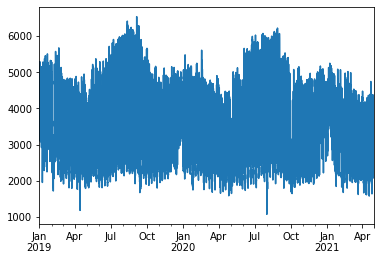

In [ ]:
import matplotlib.pyplot as plt
df_concat['elec'].plot()
plt.show()

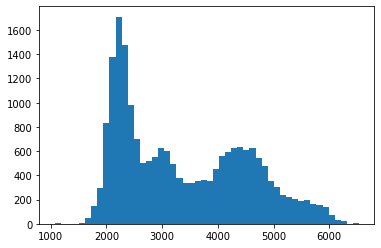

In [ ]:
plt.hist(df_concat['elec'], bins=50)
plt.show()

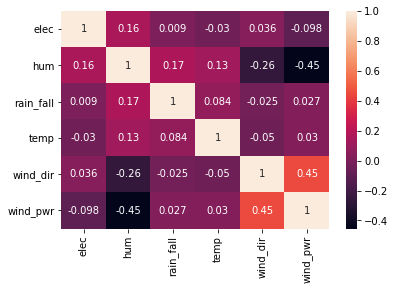

In [ ]:
import seaborn as sns
sns.heatmap(data=df_concat.corr(), annot=True)

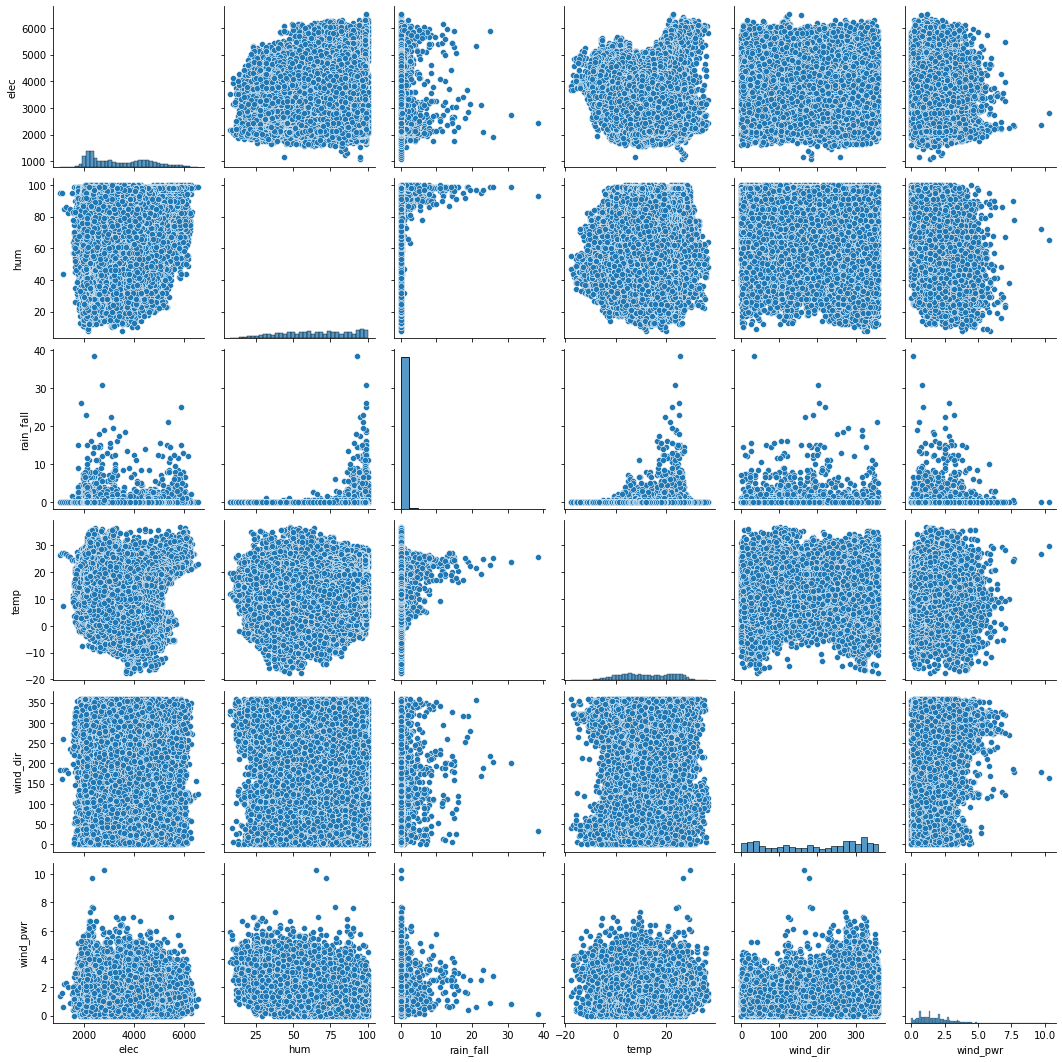

In [ ]:
sns.pairplot(df_concat)

In [ ]:
df_date_split = df_concat.copy()
df_date_split['year'] = df_date_split.index.year
df_date_split['month'] = df_date_split.index.month
df_date_split['day'] = df_date_split.index.day
df_date_split['dayofweek'] = df_date_split.index.dayofweek
df_date_split['hour'] = df_date_split.index.hour

In [ ]:
df_date_split

,elec,hum,rain_fall,rain_type,temp,wind_dir,wind_pwr,year,month,day,dayofweek,hour
2019-01-01 00:00,3330.816,56.0,0.0,None,-4.7,65.0,1.1,2019,1,1,1,0
2019-01-01 01:00,3339.200,50.0,0.0,None,-3.8,15.0,2.2,2019,1,1,1,1
2019-01-01 02:00,3287.616,54.0,0.0,None,-2.8,348.0,2.9,2019,1,1,1,2
2019-01-01 03:00,3287.040,51.0,0.0,None,-1.2,316.0,2.9,2019,1,1,1,3
2019-01-01 04:00,3372.672,49.0,0.0,None,-0.5,286.0,3.3,2019,1,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-30 19:00,3604.800,97.0,0.0,None,10.0,292.0,0.5,2021,4,30,4,19
2021-04-30 20:00,3458.944,98.0,0.0,None,9.9,272.0,1.0,2021,4,30,4,20
2021-04-30 21:00,3335.808,98.0,0.0,None,10.3,267.0,1.0,2021,4,30,4,21
2021-04-30 22:00,3230.528,85.0,0.0,None,11.5,304.0,1.8,2021,4,30,4,22


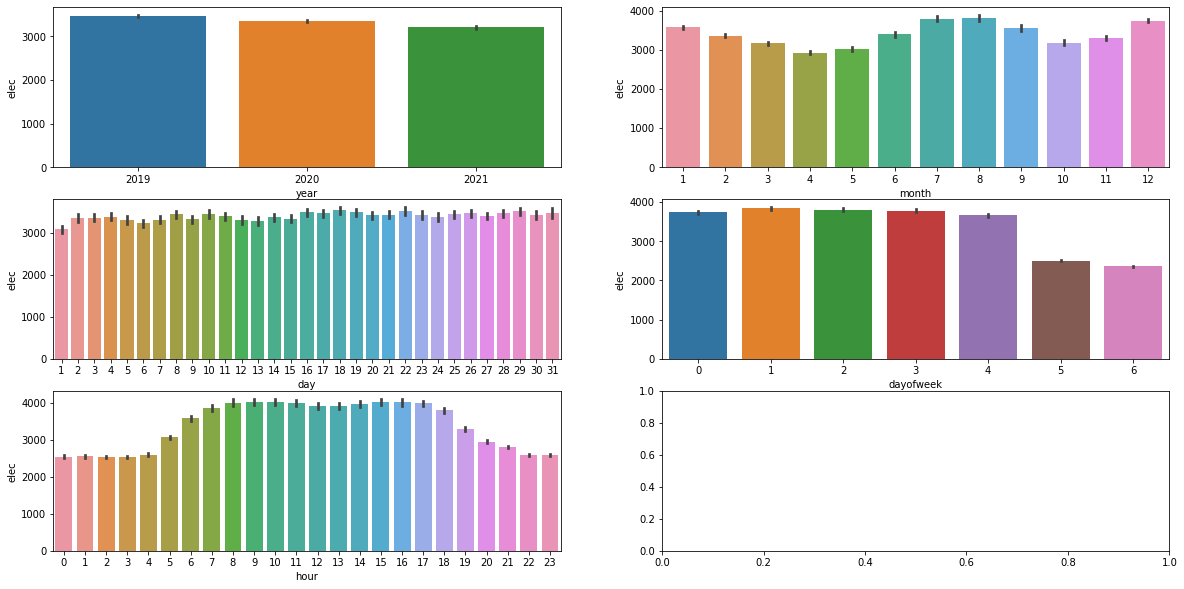

In [ ]:
figure, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(nrows=3, ncols=2, figsize=(20,10))
sns.barplot(data=df_date_split, x='year', y='elec', ax=ax1)
sns.barplot(data=df_date_split, x='month', y='elec', ax=ax2)
sns.barplot(data=df_date_split, x='day', y='elec', ax=ax3)
sns.barplot(data=df_date_split, x='dayofweek', y='elec', ax=ax4)
sns.barplot(data=df_date_split, x='hour', y='elec', ax=ax5)

In [ ]:
def isWorking(x):
  if x>7:
    if x<18:
      return 'on'
    else:
      return 'off'
  else:
    return 'off'

df_date_split['Working'] = df_date_split['hour'].apply(isWorking)
#df_date_split['Working'] = df_date_split['dayofweek'].apply(lambda x: 'off' if x > 4 else 'on')
df_date_split[:30]

,elec,hum,rain_fall,rain_type,temp,wind_dir,wind_pwr,year,month,day,dayofweek,hour,Working
2019-01-01 00:00,3330.816,56.0,0.0,None,-4.7,65.0,1.1,2019,1,1,1,0,off
2019-01-01 01:00,3339.200,50.0,0.0,None,-3.8,15.0,2.2,2019,1,1,1,1,off
2019-01-01 02:00,3287.616,54.0,0.0,None,-2.8,348.0,2.9,2019,1,1,1,2,off
2019-01-01 03:00,3287.040,51.0,0.0,None,-1.2,316.0,2.9,2019,1,1,1,3,off
2019-01-01 04:00,3372.672,49.0,0.0,None,-0.5,286.0,3.3,2019,1,1,1,4,off
2019-01-01 05:00,3560.320,47.0,0.0,None,-0.8,307.0,2.8,2019,1,1,1,5,off
2019-01-01 06:00,3610.240,47.0,0.0,None,-1.2,273.0,3.1,2019,1,1,1,6,off
2019-01-01 07:00,3779.712,49.0,0.0,None,-1.4,281.0,3.0,2019,1,1,1,7,off
2019-01-01 08:00,3616.064,52.0,0.0,None,-2.0,289.0,2.3,2019,1,1,1,8,on
2019-01-01 09:00,3285.312,48.0,0.0,None,-2.5,298.0,2.8,2019,1,1,1,9,on


In [ ]:
df_working = df_date_split.copy()
df_working = df_working[df_working['Working'] == 'on']
df_working['Working'] = df_working['dayofweek'].apply(lambda x: 'off' if x > 4 else 'on') #주말 제거
df_working = df_working[df_working['Working'] == 'on']
df_working = df_working.drop(['year', 'month', 'day', 'dayofweek', 'hour', 'Working'], axis=1)
df_working[30:60]

,elec,hum,rain_fall,rain_type,temp,wind_dir,wind_pwr
2019-01-04 08:00,5102.336,84.0,0.0,None,1.3,177.0,1.0
2019-01-04 09:00,4955.840,84.0,0.0,None,0.4,205.0,0.4
2019-01-04 10:00,4823.040,90.0,0.0,None,0.2,54.0,0.5
2019-01-04 11:00,4821.824,90.0,0.0,None,-1.7,31.0,0.9
2019-01-04 12:00,4878.720,96.0,0.0,None,-2.0,44.0,0.8
2019-01-04 13:00,4876.928,97.0,0.0,None,-2.1,41.0,1.1
2019-01-04 14:00,4758.400,97.0,0.0,None,-2.7,286.0,0.4
2019-01-04 15:00,4794.816,97.0,0.0,None,-0.9,316.0,2.4
2019-01-04 16:00,4775.488,95.0,0.0,None,-1.5,314.0,2.6
2019-01-04 17:00,4557.248,94.0,0.0,None,-1.9,322.0,2.3


In [ ]:
#근무일, 근무시간대의 data의 상관관계
df_working.corr()

,elec,hum,rain_fall,temp,wind_dir,wind_pwr
elec,1.000000,0.269307,0.096473,0.350329,-0.015462,0.004136
hum,0.269307,1.000000,0.171235,0.350316,-0.235006,-0.356174
rain_fall,0.096473,0.171235,1.000000,0.097411,-0.049028,0.061968
temp,0.350329,0.350316,0.097411,1.000000,-0.063570,-0.093509
wind_dir,-0.015462,-0.235006,-0.049028,-0.063570,1.000000,0.457056
wind_pwr,0.004136,-0.356174,0.061968,-0.093509,0.457056,1.000000


In [ ]:
#모든 data의 상관관계
df_concat.corr()

,elec,hum,rain_fall,temp,wind_dir,wind_pwr
elec,1.000000,0.156892,0.009018,-0.029694,0.035511,-0.098186
hum,0.156892,1.000000,0.169042,0.127860,-0.255455,-0.454049
rain_fall,0.009018,0.169042,1.000000,0.083914,-0.024871,0.027396
temp,-0.029694,0.127860,0.083914,1.000000,-0.049754,0.030440
wind_dir,0.035511,-0.255455,-0.024871,-0.049754,1.000000,0.452306
wind_pwr,-0.098186,-0.454049,0.027396,0.030440,0.452306,1.000000


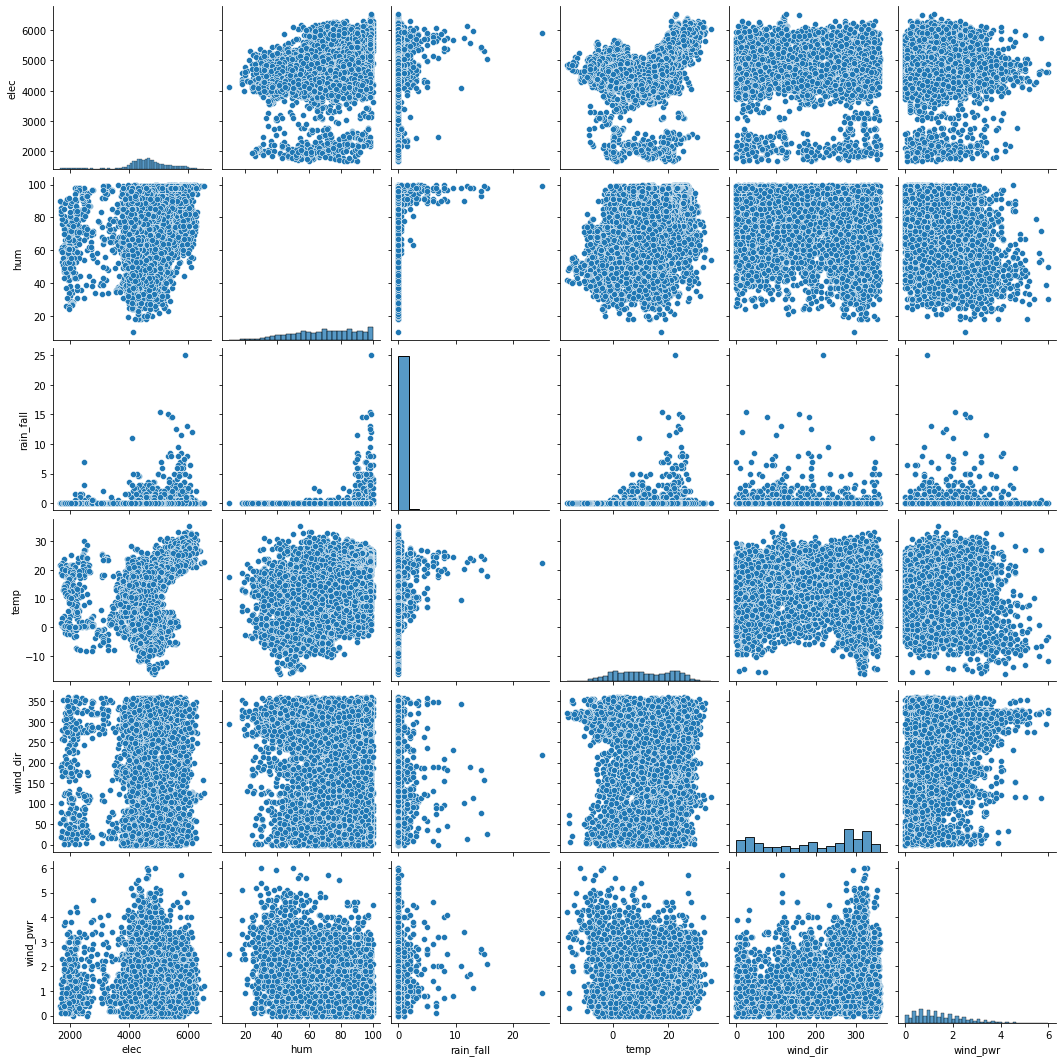

In [ ]:
sns.pairplot(df_working)